# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [15]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

##

learning_rate_pows = np.linspace(-9, -7, 8)
regularization_strength_pows = np.linspace(4, 7, 8)

jitter_power = 0.4

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

def jitter(value, power, step):
    return value + power * step / 2 * np.random.randn()

def search():
    learning_rate_pow_step = learning_rate_pows[1] - learning_rate_pows[0]
    regularization_strength_pow_step = regularization_strength_pows[1] - regularization_strength_pows[0]
    
    best = None
    best_val_acc = 0.0

    total_iteration_num = len(learning_rate_pows) * len(regularization_strength_pows)
    current_iteration = 0
    
    for learning_rate_pow in learning_rate_pows:
        for regularization_strength_pow in regularization_strength_pows:
            learning_rate = 10**jitter(
                learning_rate_pow, jitter_power, learning_rate_pow_step)
            regularization_strength = 10**jitter(
                regularization_strength_pow, jitter_power, regularization_strength_pow_step)

            print()
            print(f'rate: {learning_rate}')
            print(f'reg: {regularization_strength}')
            print()
            
            svm = LinearSVM()
            svm.train(X_train_feats, y_train,
                      learning_rate=learning_rate,
                      reg=regularization_strength,
                      num_iters=1500,
                      verbose=True,
                     )
            trained_accuracy = np.mean(y_train == svm.predict(X_train_feats))
            val_accuracy = np.mean(y_val == svm.predict(X_val_feats))
            results[(
                learning_rate,
                regularization_strength,
            )] = (
                trained_accuracy,
                val_accuracy,
            )
            print('*' * filled + '-' * (80 - filled))
            if best_val_acc < val_accuracy:
                best_val_acc = val_accuracy
                best = svm
    return best_val, best

%time best_val, best_svm = search()            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results, key=lambda x: -results[x][1]):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


rate: 9.891418123838698e-10
reg: 9346.445444048331

iteration 0 / 1500: loss 23.621341
iteration 100 / 1500: loss 23.531031
iteration 200 / 1500: loss 23.530885
iteration 300 / 1500: loss 23.484267
iteration 400 / 1500: loss 23.352917
iteration 500 / 1500: loss 23.314620
iteration 600 / 1500: loss 23.270549
iteration 700 / 1500: loss 23.244207
iteration 800 / 1500: loss 23.083468
iteration 900 / 1500: loss 23.198236
iteration 1000 / 1500: loss 23.077462
iteration 1100 / 1500: loss 22.984269
iteration 1200 / 1500: loss 22.910370
iteration 1300 / 1500: loss 22.867756
iteration 1400 / 1500: loss 22.854114

rate: 7.748628864451983e-10
reg: 39191.20156909891

iteration 0 / 1500: loss 71.199228
iteration 100 / 1500: loss 70.466379
iteration 200 / 1500: loss 69.757856
iteration 300 / 1500: loss 68.945431
iteration 400 / 1500: loss 68.237625
iteration 500 / 1500: loss 67.542985
iteration 600 / 1500: loss 66.848371
iteration 700 / 1500: loss 66.129802
iteration 800 / 1500: loss 65.403504
itera

iteration 1300 / 1500: loss 9.000072
iteration 1400 / 1500: loss 8.999996

rate: 2.106068035501324e-09
reg: 4117331.8884743466

iteration 0 / 1500: loss 6108.925208
iteration 100 / 1500: loss 193.398456
iteration 200 / 1500: loss 14.571164
iteration 300 / 1500: loss 9.168524
iteration 400 / 1500: loss 9.005084
iteration 500 / 1500: loss 9.000158
iteration 600 / 1500: loss 8.999998
iteration 700 / 1500: loss 8.999996
iteration 800 / 1500: loss 8.999997
iteration 900 / 1500: loss 8.999998
iteration 1000 / 1500: loss 8.999998
iteration 1100 / 1500: loss 8.999998
iteration 1200 / 1500: loss 9.000002
iteration 1300 / 1500: loss 8.999990
iteration 1400 / 1500: loss 8.999994

rate: 1.8506231022160344e-09
reg: 9365322.997915693

iteration 0 / 1500: loss 14697.189617
iteration 100 / 1500: loss 21.668929
iteration 200 / 1500: loss 9.010936
iteration 300 / 1500: loss 9.000008
iteration 400 / 1500: loss 8.999998
iteration 500 / 1500: loss 8.999996
iteration 600 / 1500: loss 8.999998
iteration 700 

iteration 1100 / 1500: loss 12.781360
iteration 1200 / 1500: loss 11.552160
iteration 1300 / 1500: loss 10.728555
iteration 1400 / 1500: loss 10.170949

rate: 6.646268167694657e-09
reg: 462990.0517112217

iteration 0 / 1500: loss 734.252766
iteration 100 / 1500: loss 220.024326
iteration 200 / 1500: loss 70.381832
iteration 300 / 1500: loss 26.865373
iteration 400 / 1500: loss 14.197555
iteration 500 / 1500: loss 10.511759
iteration 600 / 1500: loss 9.439359
iteration 700 / 1500: loss 9.128635
iteration 800 / 1500: loss 9.037478
iteration 900 / 1500: loss 9.010592
iteration 1000 / 1500: loss 9.003034
iteration 1100 / 1500: loss 9.000897
iteration 1200 / 1500: loss 9.000198
iteration 1300 / 1500: loss 9.000064
iteration 1400 / 1500: loss 8.999950

rate: 6.131082607410463e-09
reg: 1328687.5541425198

iteration 0 / 1500: loss 2054.961335
iteration 100 / 1500: loss 85.579061
iteration 200 / 1500: loss 11.867290
iteration 300 / 1500: loss 9.107549
iteration 400 / 1500: loss 9.003989
iterati

iteration 1300 / 1500: loss 10.272212
iteration 1400 / 1500: loss 10.005859

rate: 3.3021121455239866e-08
reg: 82576.86980114455

iteration 0 / 1500: loss 138.497316
iteration 100 / 1500: loss 52.408058
iteration 200 / 1500: loss 23.526334
iteration 300 / 1500: loss 13.868869
iteration 400 / 1500: loss 10.633022
iteration 500 / 1500: loss 9.545831
iteration 600 / 1500: loss 9.181288
iteration 700 / 1500: loss 9.061688
iteration 800 / 1500: loss 9.020933
iteration 900 / 1500: loss 9.006494
iteration 1000 / 1500: loss 9.002232
iteration 1100 / 1500: loss 9.000685
iteration 1200 / 1500: loss 9.000044
iteration 1300 / 1500: loss 8.999687
iteration 1400 / 1500: loss 8.999994

rate: 2.3739910759843367e-08
reg: 223970.56853759824

iteration 0 / 1500: loss 368.805257
iteration 100 / 1500: loss 51.396739
iteration 200 / 1500: loss 14.003042
iteration 300 / 1500: loss 9.588639
iteration 400 / 1500: loss 9.069460
iteration 500 / 1500: loss 9.008043
iteration 600 / 1500: loss 9.000901
iteration 70

iteration 1100 / 1500: loss 9.000032
iteration 1200 / 1500: loss 9.000033
iteration 1300 / 1500: loss 9.000038
iteration 1400 / 1500: loss 9.000025

rate: 9.865696938020493e-08
reg: 11328.248455795638

iteration 0 / 1500: loss 26.797585
iteration 100 / 1500: loss 20.349652
iteration 200 / 1500: loss 16.309268
iteration 300 / 1500: loss 13.670979
iteration 400 / 1500: loss 11.978918
iteration 500 / 1500: loss 10.897667
iteration 600 / 1500: loss 10.211508
iteration 700 / 1500: loss 9.773957
iteration 800 / 1500: loss 9.493030
iteration 900 / 1500: loss 9.316050
iteration 1000 / 1500: loss 9.199171
iteration 1100 / 1500: loss 9.126564
iteration 1200 / 1500: loss 9.081143
iteration 1300 / 1500: loss 9.049486
iteration 1400 / 1500: loss 9.034408

rate: 8.711412206042872e-08
reg: 30961.67357952407

iteration 0 / 1500: loss 59.803815
iteration 100 / 1500: loss 26.218809
iteration 200 / 1500: loss 14.846504
iteration 300 / 1500: loss 10.961702
iteration 400 / 1500: loss 9.675962
iteration 500

/opt/notebooks/cs231/assignment1/cs231n/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/opt/notebooks/cs231/assignment1/cs231n/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/opt/notebooks/cs231/assignment1/cs231n/classifiers/linear_svm.py:122: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/opt/notebooks/cs231/assignment1/cs231n/classifiers/linear_classifier.py:69: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad
/opt/notebooks/cs231/assignment1/cs231n/classifiers/linear_svm.py:115: RuntimeWarning: invalid value encountered in greater
  coeff_mat[non_neg_margins > 0] = 1


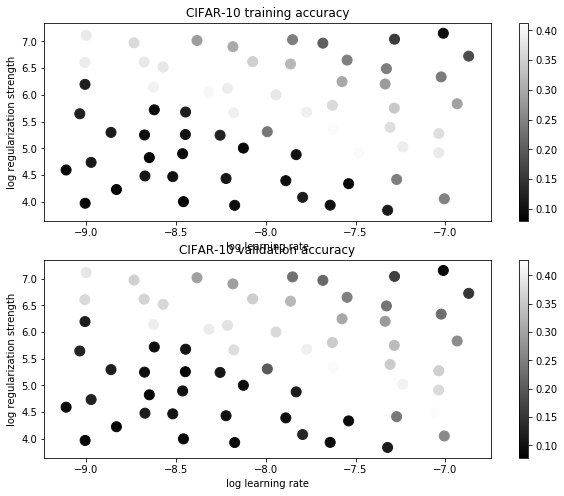

In [19]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [20]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.428


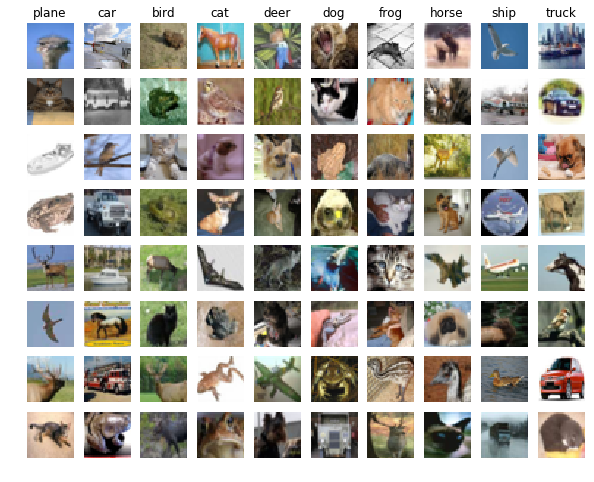

In [21]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
print(X_train_feats.shape)

In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [ ]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

In [ ]:
# play rolling sound at the end of the notebook :)
# very useful for long training

from IPython.display import HTML
video_id = 'mzAfTmC3It0'
HTML(f'<iframe width="560" height="315" src="https://www.youtube.com/embed/{video_id}?rel=0&amp;controls=1&amp;showinfo=0&autoplay=1" frameborder="0" allowfullscreen></iframe>')